In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pytrends.request import TrendReq

import pandas as pd
from pandas import Series, DataFrame

from scipy.stats import norm
from scipy.stats import shapiro, normaltest

In [2]:
def find_website(src_list):
    for el in src_list:
        if el['type']=='Website':
            return el['mid']

pytrends = TrendReq(hl='en-UK', tz=0)
airbnb_web = find_website(pytrends.suggestions('Airbnb'))
booking_web = find_website(pytrends.suggestions('Booking.com'))
kw_list = [airbnb_web, booking_web]
src_map = {airbnb_web:'Airbnb', booking_web:'Booking.com'}

In [3]:
def get_trend(geo, timeframe, kw_list=kw_list, src_map=src_map):
    pytrends = TrendReq(hl='en-UK', tz=0)
    pytrends.build_payload(kw_list, cat=0, geo=geo, timeframe=timeframe, gprop='')
    hist_data = pytrends.interest_over_time().rename(columns=src_map)
    del hist_data['isPartial']
    return hist_data

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    '''
        Save plot on file. Options:
        fig_id: filename
        tight_layout: True by default
        fig_extension: "png" by default
        resolution: 300 by default
    '''
    path = 'images/'+fig_id+'.'+fig_extension
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 1. Airbnb vs Booking.com in UK

### 1.1 Historical data (since 2008)

In [4]:
historical_UK = get_trend(geo='GB', timeframe='2008-01-01 2020-01-01', kw_list=kw_list, src_map=src_map)

Saving figure hist_trend_UK


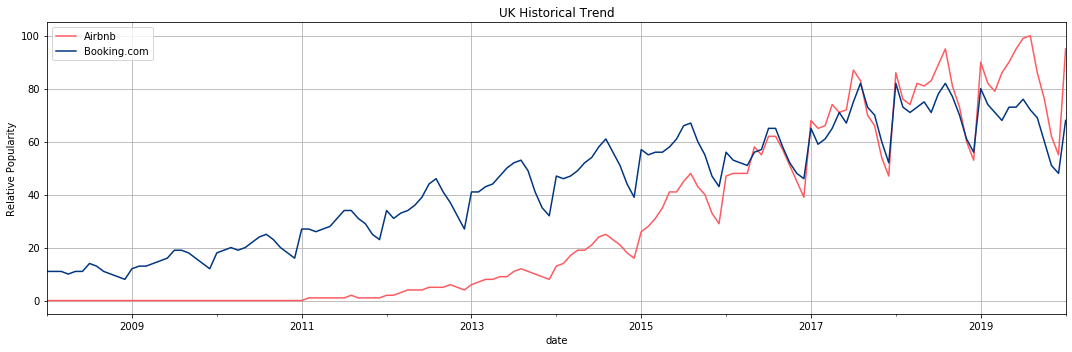

In [5]:
color_list = ['#FF5A60', '#003580']
historical_UK.plot(figsize=(15,5), color=color_list)
plt.grid(True)
plt.title('UK Historical Trend')
plt.ylabel('Relative Popularity')
save_fig('hist_trend_UK')
plt.show()

#### Popularity by month

In [6]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
historical_UK_red = historical_UK.loc['2016-01-01':]
month_freq = DataFrame({month: historical_UK_red[historical_UK_red.index.month==i+1].mean().round(2) 
                        for i, month in enumerate(months)})
month_freq

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Airbnb,77.2,67.75,66.75,72.50,75.00,76.25,84.25,85.00,73.50,66.5,55.25,48.5
Booking.com,70.2,64.75,63.75,64.25,68.75,67.00,73.50,75.25,69.25,63.0,55.00,50.5


#### Popularity by week of the year (last 5 years)

In [7]:
weekly_hist_UK = get_trend(geo='GB', timeframe='today 5-y', kw_list=kw_list, src_map=src_map)
week_freq = DataFrame({week: weekly_hist_UK[weekly_hist_UK.index.week==week].mean().round(2) for 
                       week in range(1, 54)})

 #### By day of the week 

In [8]:
daily_hist_UK = get_trend(geo='GB', timeframe='2019-01-01 2019-08-31', kw_list=kw_list, src_map=src_map)
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_freq = DataFrame({day: daily_hist_UK[daily_hist_UK.index.weekday== i].mean().round(2) 
                      for i, day in enumerate(days)})

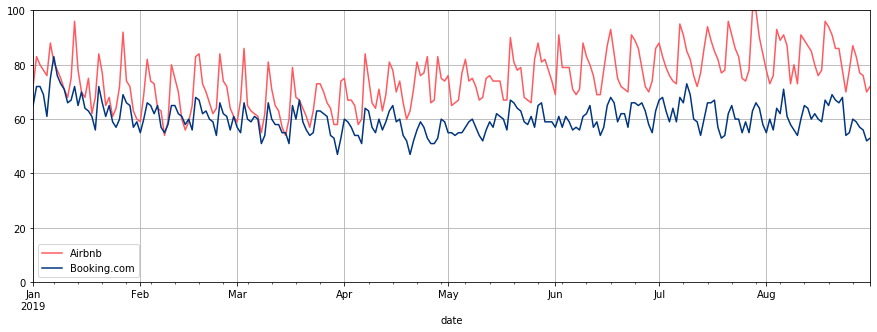

In [9]:
daily_hist_UK.plot(color=color_list, figsize=(15,5))
plt.legend()
plt.grid(True)
plt.ylim(0, 100)
plt.show()

#### By hour of the day

In [10]:
pytrends = TrendReq(hl='en-UK', tz=0)
hour_hist_UK = pytrends.get_historical_interest(kw_list, year_start=2020, month_start=2,day_start=1, hour_start=0, 
                                                year_end=2020, month_end=2, day_end=7, hour_end=0, 
                                                cat=0, geo='GB', gprop='', sleep=10).rename(columns=src_map)
del hour_hist_UK['isPartial']

hour_freq = DataFrame({hour: hour_hist_UK[hour_hist_UK.index.hour== hour].mean().round(2) for hour in range(24)})

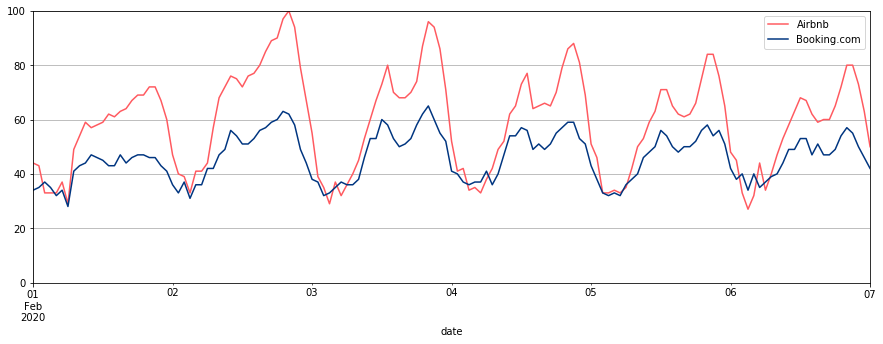

In [11]:
hour_hist_UK.plot(color=color_list, figsize=(15,5))
plt.legend()
plt.grid(True)
plt.ylim(0, 100)
plt.show()

#### Results

Saving figure all_seasonalities


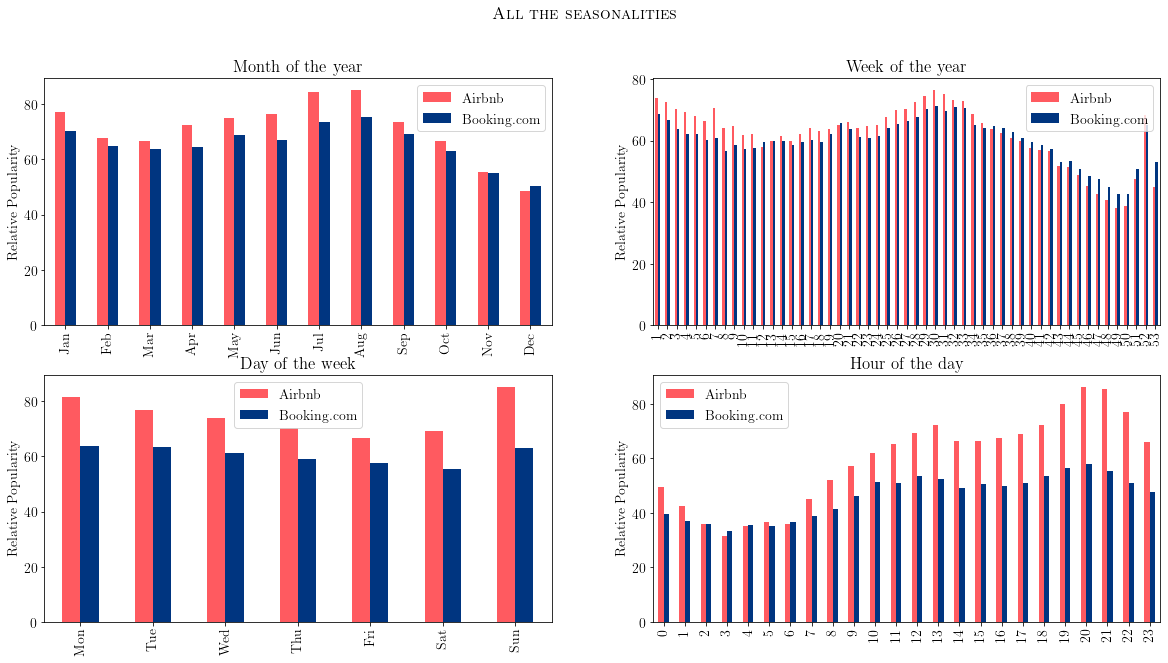

In [85]:
fig= plt.figure(figsize=(20,10))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig.suptitle(r'\textsc{All the seasonalities}')


fig.tight_layout()
fig.subplots_adjust(top=.88)

# Popularity by month
ax1 = fig.add_subplot(2,2,1)
month_freq.transpose().plot(ax=ax1, kind='bar', color=color_list)
ax1.set_title('Month of the year')
ax1.set_ylabel('Relative Popularity')

# Popularity by week of the year

ax2 = fig.add_subplot(2,2,2)
week_freq.transpose().plot(ax=ax2, kind='bar', color=color_list)
ax2.set_title('Week of the year')
ax2.set_ylabel('Relative Popularity')

ax3 = fig.add_subplot(2,2,3)
day_freq.transpose().plot(ax=ax3, kind='bar', color=color_list)
ax3.set_title('Day of the week')
ax3.set_ylabel('Relative Popularity')

ax4 = fig.add_subplot(2,2,4)
hour_freq.transpose().plot(ax=ax4, kind='bar', color=color_list)
ax4.set_title('Hour of the day')
ax4.set_ylabel('Relative Popularity')

save_fig('all_seasonalities', tight_layout=False)

plt.show()

# 2. The whole World

In [13]:
historical_World = get_trend(geo='', timeframe='today 5-y')
n_fit = len(historical_World)
print(n_fit)

261


Saving figure hist_trend_world


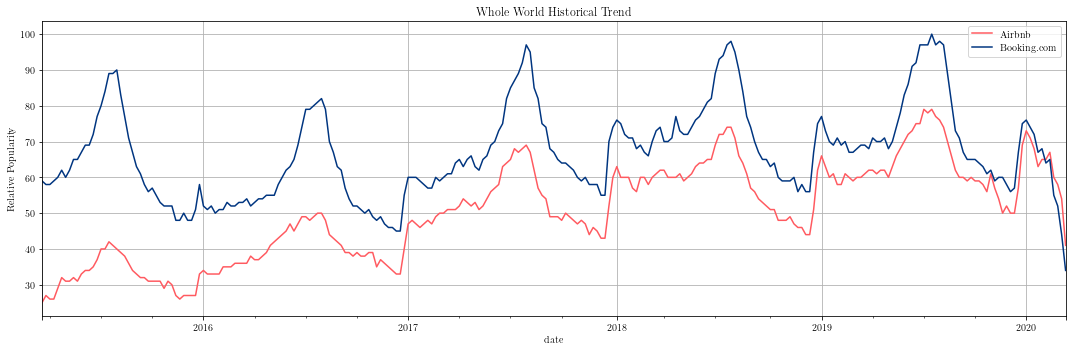

In [14]:
historical_World.plot(figsize=(15,5), color=color_list)
plt.title('Whole World Historical Trend')
plt.ylabel('Relative Popularity')
plt.grid(True)
save_fig('hist_trend_world')
plt.show()

### 1.2.1 Time Series analisys

In [71]:
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters() # Needed to keep using df.plot() after importing fbprophet


def make_df_for_fit_ts(col_name, ts):
    df = DataFrame({'ds':ts.index.values, 'y':ts[col_name].values})
    return df


def make_forecast_analysis(col_name, ts=historical_World, periods=52, freq='W', y_s=True, w_s=False, d_s=False):
    df = make_df_for_fit_ts(col_name, ts)
    model = Prophet(yearly_seasonality=y_s, weekly_seasonality=w_s, daily_seasonality=d_s)
    model.fit(df)
    future = model.make_future_dataframe(periods=periods, freq=freq)
    forecast = model.predict(future) 
    res = np.zeros(len(forecast))
    res[:len(df)] = df.y.values - forecast.yhat.values[:len(df)]
    res[len(df):] = np.nan
    forecast['residuals'] = res
    return model, forecast


def residual_test(res, ax, n_bins=15):
    res = res[~np.isnan(res)]
    mu, sigma = res.mean(), res.std()
    x = np.linspace(sigma*norm.ppf(.001), sigma*norm.ppf(.999), 100)
    rv = norm()
    ax.plot(x, rv.pdf((x-mu)/sigma)/sigma, color='red', label='Estimated norm pdf')
    ax.hist(res, bins=n_bins, density=True)
    ax.legend()
    
def normal_test(res):
    res = res[~np.isnan(res)]
    print('Shapiro test. p-value: %.2f' % shapiro(res)[1])
    print('Normal test. p-value: %.2f' % normaltest(res).pvalue)
    

In [74]:
airbnb_m, airbnb_forecast = make_forecast_analysis('Airbnb', freq='W', y_s=True, w_s=False, d_s=False)

booking_m, booking_forecast = make_forecast_analysis('Booking.com', freq='W', y_s=True, w_s=False, d_s=False)

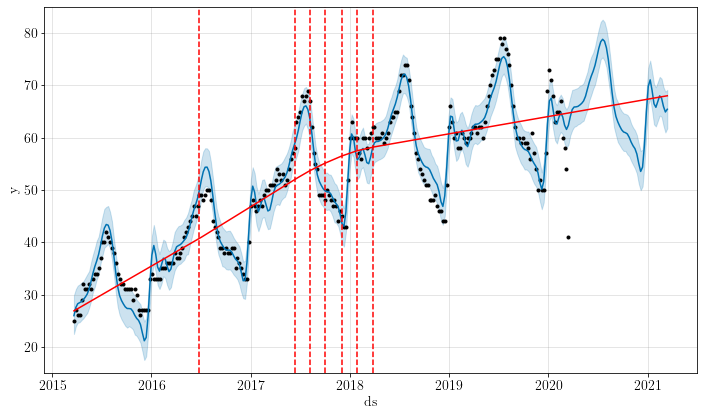

In [75]:
from fbprophet.plot import add_changepoints_to_plot
fig = airbnb_m.plot(airbnb_forecast)
plt.ylim(15,85)
a = add_changepoints_to_plot(fig.gca(), airbnb_m, airbnb_forecast)

Saving figure decomposition_fb_only


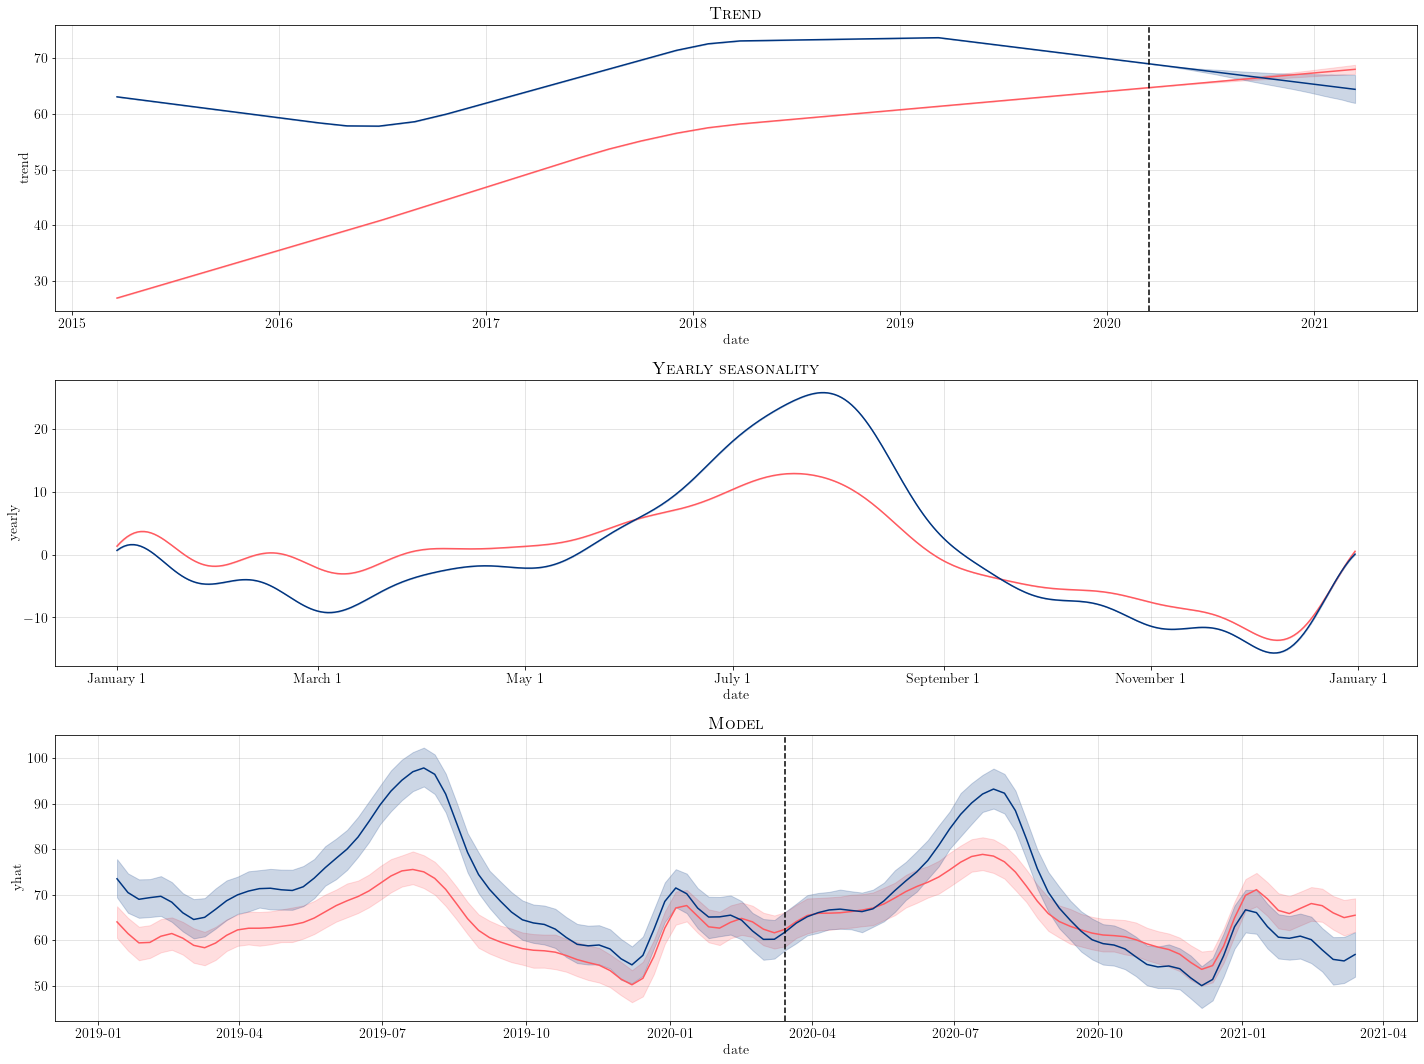

In [76]:
from custom_fbprophet import custom_plot_forecast_component, custom_plot_yearly

fig = plt.figure(figsize=(20,15))
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=14)

ax1 = fig.add_subplot(3,1,1)
ax1.set_title(r'\textsc{Trend}')
custom_plot_forecast_component(airbnb_m, fcst=airbnb_forecast, name='trend', color=color_list[0], ax=ax1)
custom_plot_forecast_component(booking_m, fcst=booking_forecast, name='trend', color=color_list[1], ax=ax1)
plt.grid(True)
ax1.axvline(x=historical_World.index[-1], color='black', ls='--')
ax1.set_xlabel('date')

ax2 = fig.add_subplot(3,1,2)
ax2.set_title(r'\textsc{Yearly seasonality}')
custom_plot_yearly(airbnb_m, color=color_list[0], ax=ax2)
custom_plot_yearly(booking_m, color=color_list[1], ax=ax2)
#ax2.axvline(x=historical_World.index[-1], color='grey', ls='--')
ax2.set_xlabel('date')

ax3 = fig.add_subplot(3,1,3)
ax3.set_title(r'\textsc{Model}')
custom_plot_forecast_component(airbnb_m, fcst=airbnb_forecast.iloc[199:], name='yhat', color=color_list[0], ax=ax3)
custom_plot_forecast_component(booking_m, fcst=booking_forecast.iloc[199:], name='yhat', color=color_list[1], ax=ax3)
ax3.axvline(x=historical_World.index[-1], color='black', ls='--')
ax3.set_xlabel('date')

save_fig('decomposition_fb_only')

#### Including COVID-19 in the forecasts

Take the last values, subtract the yearly seasonality, fit the trend and then update the forecasts.

#### Residuals

Saving figure residuals_plot


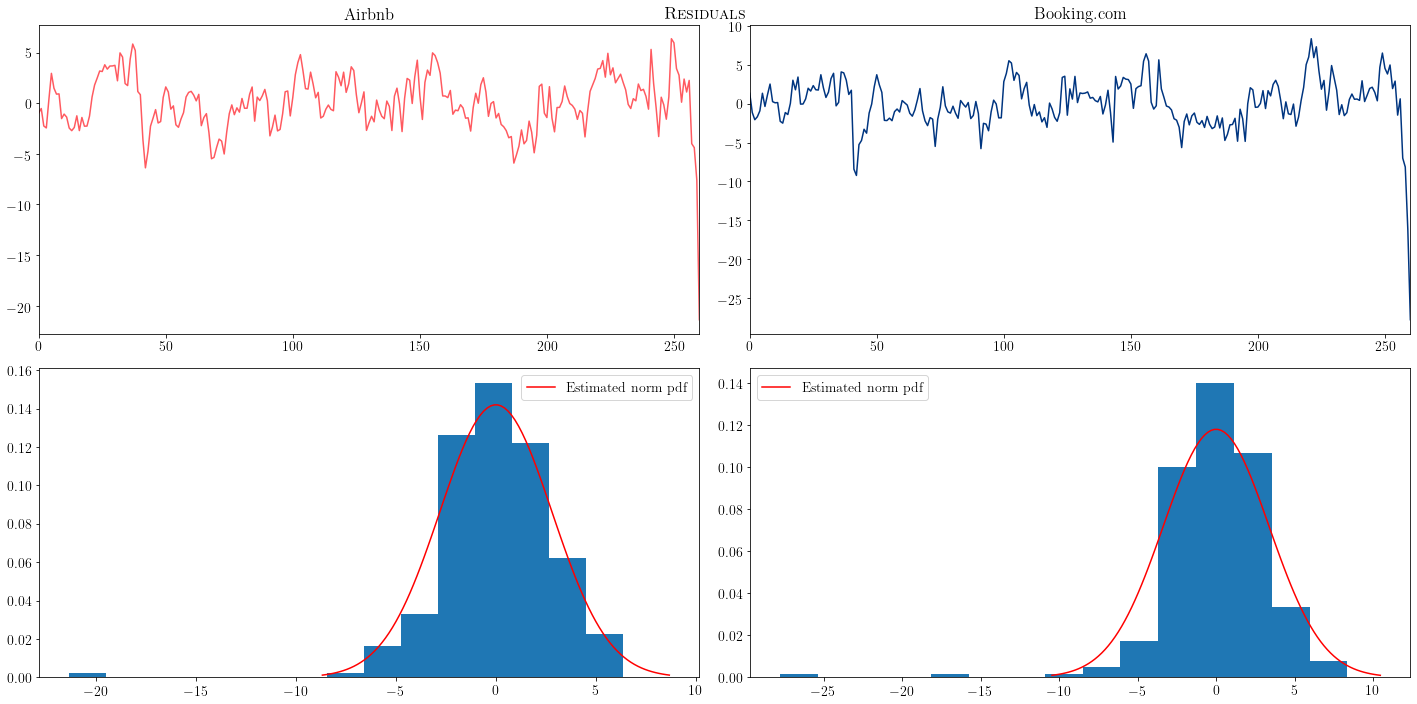

In [86]:
fig = plt.figure(figsize=(20,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig.suptitle(r'\textsc{Residuals}')

ax1 = fig.add_subplot(2,2,1)
airbnb_forecast.residuals.iloc[:n_fit].plot(color=color_list[0], ax=ax1)
ax1.set_title('Airbnb')

ax2 = fig.add_subplot(2,2,2)
booking_forecast.residuals.iloc[:n_fit].plot(color=color_list[1], ax=ax2)
ax2.set_title('Booking.com')

ax3 = fig.add_subplot(2,2,3)
residual_test(airbnb_forecast.residuals[:n_fit], ax=ax3)
#ax3.set_title('Airbnb')

ax4 = fig.add_subplot(2,2,4)
residual_test(booking_forecast.residuals[:n_fit], ax=ax4)
#ax4.set_title('Booking.com')

save_fig('residuals_plot')
plt.show()

In [81]:
print('Airbnb residuals test')
normal_test(airbnb_forecast[:n_fit-4].residuals)

print()

print('Booking.com residuals test')
normal_test(booking_forecast[:n_fit-4].residuals)

Airbnb residuals test
Shapiro test. p-value: 0.91
Normal test. p-value: 0.86

Booking.com residuals test
Shapiro test. p-value: 0.06
Normal test. p-value: 0.16
